## 1. Importing Python Libraries:

In [1]:
import numpy as np
import pandas as pd
import csv
import mysql.connector
from datetime import datetime
from pytz import timezone
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, mean_squared_error as mse

## 2. Importing the Data Sets:

In [2]:
# Importing the Twitter Data:
twitter_df = pd.read_csv("../data/twitter.csv")

In [3]:
# Importing Industry Categories Table:
industries_df = pd.read_csv("../data/industries.csv")
companies_df = pd.read_csv("../data/companies.csv")

In [4]:
# Importing the Stock Price Data:
stocks_df = pd.read_csv("../data/stock_prices.csv")

## 3. Creating the Labeled Training Data Set:

In [5]:
# helper function to convert utc to EST date
eastern = timezone('US/Eastern')
def utc_to_est(utc):
    return datetime.fromtimestamp(utc, tz = eastern)

#create new stocks column with datetime format of daily market close times
stocks_df["date"] = pd.to_datetime(stocks_df["date"]).values.astype(np.int64) // 10**6
stocks_df["date"] = (stocks_df["date"] + 57600000)//1000
stocks_df['datetime'] = stocks_df['date'].apply(utc_to_est)

# created new twitter column with datetime format of daily market close times

twitter_df["date"] = pd.to_datetime(twitter_df["date"]).values.astype(np.int64) // 10**6
twitter_df["date"] = (twitter_df["date"])//1000
twitter_df['datetime'] = twitter_df['date'].apply(utc_to_est)

# add column that helps in counting posts when grouped
twitter_df['num_tweets'] = 1

In [6]:
#helper function that takes a dataframe and returns separate dataframes for each company
def separate_twitter(twitter_df, by='all'):
    if by not in ['all', 'company', 'industry']:
        print('argument invalid: must be = <all>, <company>, or <industry>')
        pass
    else:
        if by == 'industry':
            temp = twitter_df.merge(companies_df[['id', 'industry_id']], left_on = 'company_id', right_on='id')
            return [temp[temp['industry_id']==i][['industry_id', 'datetime', 'overall_sentiment', 'negative_sentiment', 'positive_sentiment', 'neutral_sentiment', 'num_tweets']] for i in temp.industry_id.unique()]
        elif by == 'company':
            return [twitter_df[twitter_df['company_id']==i][['company_id', 'datetime', 'overall_sentiment', 'negative_sentiment', 'positive_sentiment', 'neutral_sentiment', 'num_tweets']] for i in twitter_df.company_id.unique()]
        else:
            return [twitter_df[['company_id', 'datetime','overall_sentiment', 'negative_sentiment', 'positive_sentiment', 'neutral_sentiment', 'num_tweets']]]

In [7]:
#groups data for a single company using sliding window - number of days specified in call
def group_data(df, by='all', days = 1):
    if by not in ['all', 'company', 'industry']:
        print('invalid arg: must be in [all, company, industry]')
        pass
    else:
        if by=='industry':
            i_id = df.industry_id.unique()[0] #save industry_id
            temp_df = df[['datetime', 'overall_sentiment', 'negative_sentiment', 'positive_sentiment', 'neutral_sentiment', 'num_tweets']].groupby(pd.Grouper(key='datetime', freq='24h', base=11, label='right')).sum() #groupby day
            min_date = min(temp_df.index)
            max_date = max(temp_df.index)
            date_idx = [i for i in pd.date_range(min_date, max_date)] #new index
            temp_df = temp_df.reindex(date_idx).fillna(0).rolling(days).sum()[days-1:] #make dataframe with rolling window sum
            temp_df['industry_id'] = i_id #restore industry_id
            temp_df.reset_index(inplace=True)
            return temp_df
        elif by=='company':
            c_id = df.company_id.unique()[0] #save company_id
            temp_df = df[['datetime', 'overall_sentiment', 'negative_sentiment', 'positive_sentiment', 'neutral_sentiment', 'num_tweets']].groupby(pd.Grouper(key='datetime', freq='24h', base=11, label='right')).sum() #groupby day
            min_date = min(temp_df.index)
            max_date = max(temp_df.index)
            date_idx = [i for i in pd.date_range(min_date, max_date)] #new index
            temp_df = temp_df.reindex(date_idx).fillna(0).rolling(days).sum()[days-1:] #make dataframe with rolling window sum
            temp_df['company_id'] = c_id #restore company_id
            temp_df.reset_index(inplace=True)
            return temp_df
        else:
            return pd.concat([group_data(d, 'company', days) for d in separate_twitter(df, 'company')])
    
    

In [8]:
def make_dataframes(df, separation='all', lookback=1, min_date = None, max_date = None):
    if min_date:
        df = df[df['datetime'] >= pd.to_datetime(min_date).tz_localize('US/Eastern')]
    if max_date:
        df = df[df['datetime'] <= pd.to_datetime(max_date).tz_localize('US/Eastern')]
    dfs = []
    separated = separate_twitter(df, separation)
    for d in separated:
        temp = group_data(d, separation, lookback)
        for i in ['overall_sentiment', 'negative_sentiment', 'positive_sentiment', 'neutral_sentiment']: #iterate over scores columns
            temp['avg_{}'.format(i)] = temp[i]/temp['num_tweets'].apply(lambda x: max(x, 1)) #set avgerage weighted scores columns
        temp = temp.merge(stocks_df[['company_id', 'datetime', 'change_percent']], on=['company_id', 'datetime']) #add change_percent column
        dfs.append(temp)
    return dfs

In [9]:
model_dfs = make_dataframes(twitter_df, lookback = 1, min_date = '2014-03-01')

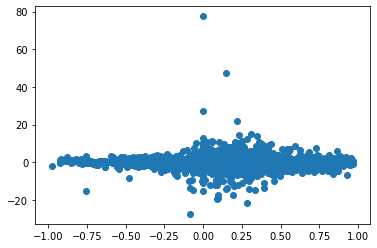

In [10]:
plt.scatter(model_dfs[0].avg_overall_sentiment, model_dfs[0].change_percent)

## 4. Building the Baselines:

### 4.1 Multi-linear Regression Model:

In [22]:
# Linear Regression Baseline:

lookback_days = [1, 3, 6, 10, 15]

for i in lookback_days:
    full_df = make_dataframes(twitter_df, lookback = i)[0]
    X = full_df[['avg_overall_sentiment', 'avg_positive_sentiment', 'avg_negative_sentiment', 'avg_neutral_sentiment', 'num_tweets']]
    y = full_df['change_percent']
    X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.25, random_state = 6240)
    ln = LinearRegression(normalize=True).fit(X_train, y_train)
    ln_pred = ln.predict(X_test)
    ln_f1 = f1_score((ln_pred > 0), y_test >0)
    print('r-squared for {0} day lookup is {1}'.format(i, ln.score(X_train, y_train)))
    print('f1 for {0} day lookup is {1}'.format(i, ln_f1))

r-squared for 1 day lookup is 0.00043722372689702915
f1 for 1 day lookup is 0.6546791990192071
r-squared for 3 day lookup is 0.0008295367286418331
f1 for 3 day lookup is 0.641718052307038
r-squared for 6 day lookup is 0.0007833224582839415
f1 for 6 day lookup is 0.6390408077408497
r-squared for 10 day lookup is 0.0006316894589113442
f1 for 10 day lookup is 0.6609923188706662
r-squared for 15 day lookup is 0.0010286548402231865
f1 for 15 day lookup is 0.6688741721854304


### 4.2 Logistic Regression Model:

In [23]:
#helper function that finds optimal C for a given training set (logistic regression)

def cross_validate_logreg(X_train, y_train, c_s = [0.1, 0.3, 1, 3, 10, 30, 100]):
    c_s = [0.1, 0.3, 1, 3, 10, 30, 100]
    lg_cv = LogisticRegressionCV(Cs = c_s, scoring='f1').fit(X_train, y_train)
    return c_s[np.argmax(np.mean(lg_cv.scores_[True],axis=0))], np.max(np.mean(lg_cv.scores_[True], axis=0))

In [24]:
def logreg_by_lookback(twitter_df, lookback = [1], c_s = [0.1, 0.3, 1, 3, 10, 30, 100]):
    for i in lookback:
        full_df = make_dataframes(twitter_df, lookback = i)[0]
        X = full_df[['avg_overall_sentiment', 'avg_positive_sentiment', 'avg_negative_sentiment', 'avg_neutral_sentiment', 'num_tweets']]
        y = full_df['change_percent'] > 0
        X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.25, random_state = 6240)
        best_c, f1_score = cross_validate_logreg(X_train, y_train, c_s)
        print('Best f1_score = {0} for {1} day lookback with C = {2}'.format(f1_score, i, best_c))

In [25]:
logreg_by_lookback(twitter_df, lookback = [1, 3, 6, 10, 15])

Best f1_score = 0.6520373662148338 for 1 day lookback with C = 0.1
Best f1_score = 0.650849158944005 for 3 day lookback with C = 0.1
Best f1_score = 0.6836000835664533 for 6 day lookback with C = 0.1
Best f1_score = 0.6794265341468233 for 10 day lookback with C = 0.1
Best f1_score = 0.6761225260829554 for 15 day lookback with C = 0.1


In [15]:
# test out best logistic regression model

full_df = make_dataframes(twitter_df, lookback = 10, min_date = '2014-03-01')[0]
X = full_df[['avg_overall_sentiment', 'avg_positive_sentiment', 'avg_negative_sentiment', 'avg_neutral_sentiment', 'num_tweets']]
y = full_df['change_percent'] > 0
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.25, random_state = 6240)
lg = LogisticRegression(C=30).fit(X_train, y_train)
lg_preds = lg.predict(X_test)
f1 = f1_score(lg_preds, y_test)
print('f1 score :{0}'.format)

<built-in method format of str object at 0x000001D8A05AB170>
